In [1]:
!pip install kagglehub[pandas-datasets]

Dataset downloaded to: /kaggle/input/cell-images-for-detecting-malaria
Parasitized samples: 13779
Uninfected samples: 13779


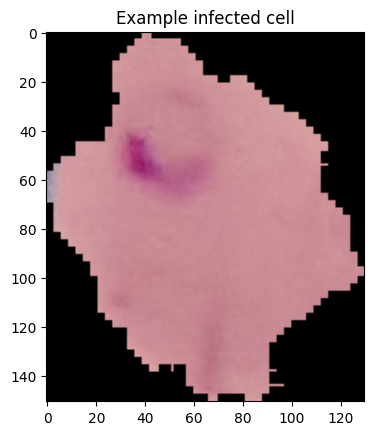

In [2]:
# pip install kagglehub
import kagglehub
import os

# Download the dataset (latest version)
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Dataset downloaded to:", path)

# Now you can explore images in the folder
# Example: count files or preview some
import glob

infected_images = glob.glob(os.path.join(path, "cell_images/Parasitized/*.png"))
uninfected_images = glob.glob(os.path.join(path, "cell_images/Uninfected/*.png"))

print("Parasitized samples:", len(infected_images))
print("Uninfected samples:", len(uninfected_images))

# Example: view one image with matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(infected_images[0])
plt.imshow(img)
plt.title("Example infected cell")
plt.show()


In [3]:

import sys

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from PIL import Image

In [4]:
# Label them and combine
infected = [(path, 1) for path in infected_images]
uninfected = [(path, 0) for path in uninfected_images]
all_data = infected + uninfected

# Split into train (80%) and a temporary set (20%)
train_data, temp_data = train_test_split(all_data, test_size=0.2, random_state=42, shuffle=True)

# Split the temporary set (20% of total) into validation (10% of total) and test (10% of total)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Train samples: 22046
Validation samples: 2756
Test samples: 2756


In [5]:
class MalariaDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
train_transform = transforms.Compose(
    [
      # For Exercise 2 - Add image transforms here before ToTensor()
      transforms.Resize((128, 128)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(45),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.01, 2.0)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = MalariaDataset(train_data, transform=train_transform)
val_dataset = MalariaDataset(val_data, transform=test_transform)
test_dataset = MalariaDataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

class_labels = {0: "Uninfected", 1: "Infected"}
classes = ("Uninfected", "Parasitized")

print("Batches in train:", len(train_loader))
print("Batches in validation:", len(val_loader))

Batches in train: 87
Batches in validation: 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Uninfected Parasitized Uninfected Uninfected Uninfected Parasitized Parasitized Uninfected


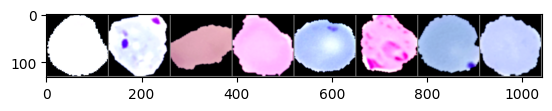

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))

# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
def train_epoch(model, dataloader, device, optimizer, criterion, epoch):
    # We set the model to be in training mode
    model.train()

    total_train_loss = 0.0
    total_correct = 0
    dataset_size = 0

    # Lists to store batch-level metrics
    batch_losses = []
    batch_accuracies = []

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    # We iterate through all batches - 1 step is 1 batch of batch_size images
    for step, (images, labels) in bar:
        # We take the images and their labels and push them on GPU
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        # Reset gradients
        optimizer.zero_grad()

        # Obtain predictions
        pred = model(images)

        # Compute loss for this batch
        loss = criterion(pred, labels)

        # Compute gradients for each weight (backpropagation)
        loss.backward()

        # Update weights based on gradients (gradient descent)
        optimizer.step()

        # --- Metrics Calculation ---
        batch_loss = loss.item()
        total_train_loss += (batch_loss * batch_size)
        
        _, predicted = torch.max(pred, 1)
        batch_correct = (predicted == labels).sum().item()
        total_correct += batch_correct
        
        dataset_size += batch_size
        
        # Store batch-level metrics
        batch_acc = batch_correct / batch_size
        batch_losses.append(batch_loss)
        batch_accuracies.append(batch_acc)

        # Update progress bar with running epoch averages
        epoch_loss = np.round(total_train_loss / dataset_size, 4)
        epoch_acc = np.round(total_correct / dataset_size, 4)
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Acc=epoch_acc)
    
    # Calculate final epoch averages
    avg_epoch_loss = total_train_loss / dataset_size
    avg_epoch_acc = total_correct / dataset_size
    
    return avg_epoch_loss, avg_epoch_acc, batch_losses, batch_accuracies

In [10]:
def valid_epoch(model, dataloader, device, criterion, epoch, name="Valid"):
    # We set the model in evaluation mode
    model.eval()

    total_val_loss = 0.0
    dataset_size = 0

    # We keep track of correct predictions
    correct = 0

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        pred = model(images)
        loss = criterion(pred, labels)

        # The raw output of the model is a score for each class
        # We keep the index of the class with the highest score as the prediction
        _, predicted = torch.max(pred, 1)

        # We see how many predictions match the ground truth labels
        correct += (predicted == labels).sum().item()

        # We compute evaluation metrics - loss and accurarcy
        total_val_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss_rounded = np.round(total_val_loss / dataset_size, 4)
        accuracy_rounded = np.round(100 * correct / dataset_size, 4)

        # Use a dict to set postfix with a dynamic name
        postfix_dict = {'Epoch': epoch, f'{name}_Acc': accuracy_rounded, f'{name}_Loss': epoch_loss_rounded}
        bar.set_postfix(**postfix_dict)

    avg_epoch_loss = total_val_loss / dataset_size
    avg_epoch_acc = correct / dataset_size # Return as 0-1

    return avg_epoch_acc, avg_epoch_loss

In [11]:
def run_training(model, criterion, optimizer, scheduler, num_epochs):
    # Check if we are using GPU
    if torch.cuda.is_available():
        print(f"[INFO] Using GPU: {torch.cuda.get_device_name()}\n")

    # For keeping track of the best validation accuracy
    top_accuracy = 0.0

    # History tracking
    history = {
        'epoch_train_loss': [],
        'epoch_train_acc': [],
        'epoch_val_loss': [],
        'epoch_val_acc': [],
        'batch_train_loss': [],
        'batch_train_acc': []
    }

    # We train the model for a number of epochs
    for epoch in range(num_epochs):

        # --- Training ---
        # Get epoch averages and batch-level lists
        train_loss, train_acc, b_losses, b_accs = train_epoch(
            model, train_loader, device, optimizer, criterion, epoch
        )
        # Store metrics
        history['epoch_train_loss'].append(train_loss)
        history['epoch_train_acc'].append(train_acc)
        history['batch_train_loss'].extend(b_losses) # .extend adds all items from the list
        history['batch_train_acc'].extend(b_accs)
        

        # --- Validation ---
        # For validation we do not keep track of gradients
        with torch.no_grad():
            val_acc, val_loss = valid_epoch(
                model, val_loader, device, criterion, epoch, name="Valid"
            )
            # Store metrics
            history['epoch_val_loss'].append(val_loss)
            history['epoch_val_acc'].append(val_acc)
        
        # --- Scheduler & Model Checkpointing ---
        scheduler.step(val_loss) # Step scheduler based on validation loss
        print(f"Current LR: {scheduler.get_last_lr()}")
        
        if val_acc > top_accuracy: # Check against validation accuracy
            print(f"Validation Accuracy Improved ({top_accuracy:.4f} ---> {val_acc:.4f})")
            top_accuracy = val_acc
            # Optional: Save your best model here
            # torch.save(model.state_dict(), "cnn_malaria_best.pth")
        print()
        
    # --- Final Test ---
    print("Training Complete. Running on Test Set...")
    with torch.no_grad():
        test_acc, test_loss = valid_epoch(
            model, test_loader, device, criterion, epoch="Test", name="Test"
        )
    
    print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
    print(f"Final Test Loss: {test_loss:.4f}")
    
    # Store final test results in history
    history['final_test_acc'] = test_acc
    history['final_test_loss'] = test_loss
    
    return history

In [12]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [13]:
class CNN_MALARIA(nn.Module):

    def __init__(self, params):

        super(CNN_MALARIA, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

        self.activation = nn.GELU()

    def forward(self,X):

        X = self.activation(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = self.activation(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.activation(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.activation(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = self.activation(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return X

In [14]:
params_model={
        "shape_in": (3,128,128),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}


model = CNN_MALARIA(params_model)
model.to(device)

CNN_MALARIA(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (activation): GELU(approximate='none')
)

In [15]:
# Hyperparameters
learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss() # this parameter relaxes the confidence requirement

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

from torch.optim.lr_scheduler import ReduceLROnPlateau

# used for lowering the learning rate with * @factor after @patience epochs
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.1,
                              patience=2)

In [16]:
history = run_training(model, criterion, optimizer, scheduler, epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 11/11 [00:31<00:00,  2.85s/it, Epoch=0, Valid_Acc=91.5, Valid_Loss=0.236]
Current LR: [0.001]
Validation Accuracy Improved (0.0000 ---> 0.9147)

100%|██████████| 11/11 [00:09<00:00,  1.22it/s, Epoch=1, Valid_Acc=95.5, Valid_Loss=0.145]
Current LR: [0.001]
Validation Accuracy Improved (0.9147 ---> 0.9546)

100%|██████████| 11/11 [00:07<00:00,  1.42it/s, Epoch=2, Valid_Acc=95.5, Valid_Loss=0.14] 
Current LR: [0.001]
Validation Accuracy Improved (0.9546 ---> 0.9554)

100%|██████████| 11/11 [00:07<00:00,  1.40it/s, Epoch=3, Valid_Acc=95.5, Valid_Loss=0.139]
Current LR: [0.001]

100%|██████████| 11/11 [00:09<00:00,  1.16it/s, Epoch=4, Valid_Acc=95.9, Valid_Loss=0.141]
Current LR: [0.001]
Validation Accuracy Improved (0.9554 ---> 0.9590)

100%|██████████| 11/11 [00:07<00:00,  1.51it/s, Epoch=5, Valid_Acc=95.8, Valid_Loss=0.135]
Current LR: [0.001]

100%|██████████| 11/11 [00:07<00:00,  1.45it/s, Epoch=6, Valid_Acc=95.9, Valid_Loss=0.133]
Current L

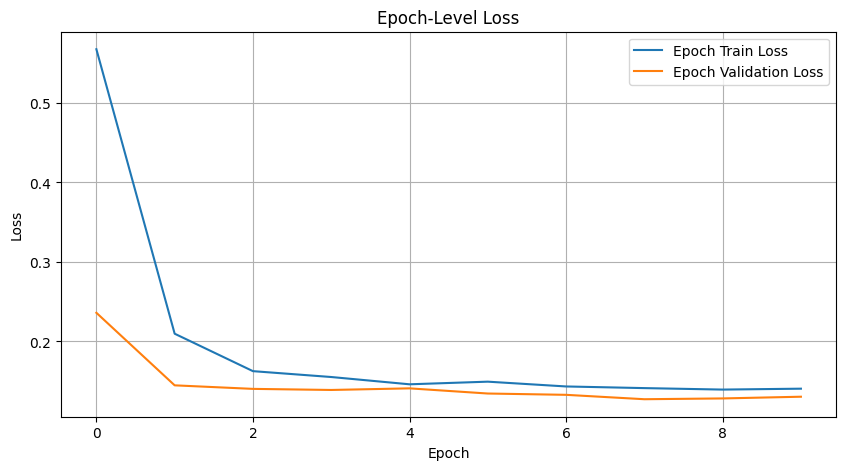

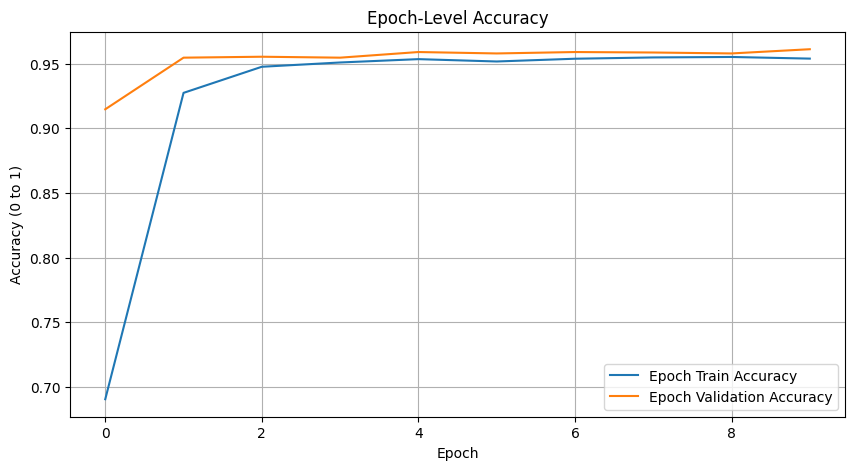

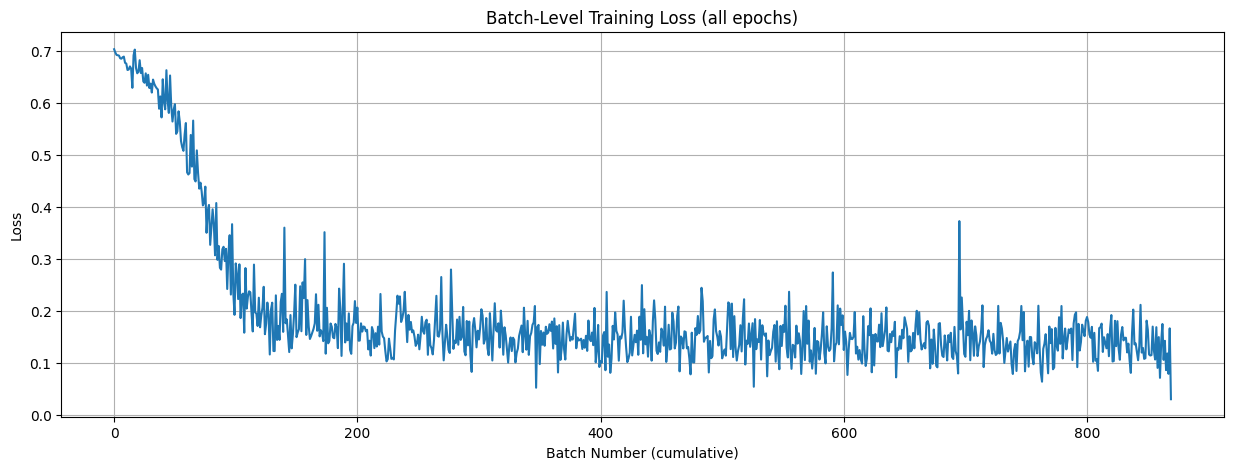

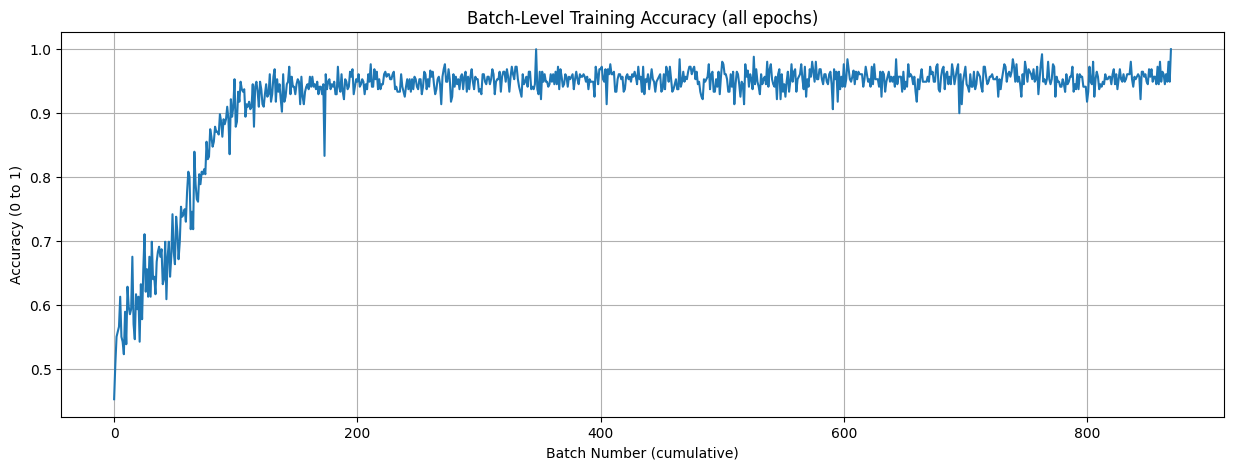

In [22]:
import matplotlib.pyplot as plt

# --- Plot 1: Epoch Loss (Train vs. Validation) ---
plt.figure(figsize=(10, 5))
plt.plot(history['epoch_train_loss'], label='Epoch Train Loss')
plt.plot(history['epoch_val_loss'], label='Epoch Validation Loss')
plt.title('Epoch-Level Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Epoch Accuracy (Train vs. Validation) ---
plt.figure(figsize=(10, 5))
plt.plot(history['epoch_train_acc'], label='Epoch Train Accuracy')
plt.plot(history['epoch_val_acc'], label='Epoch Validation Accuracy')
plt.title('Epoch-Level Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (0 to 1)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 3: Batch-Level Training Loss ---
# This will be a noisy plot, but it shows learning dynamics
plt.figure(figsize=(15, 5))
plt.plot(history['batch_train_loss'])
plt.title('Batch-Level Training Loss (all epochs)')
plt.xlabel('Batch Number (cumulative)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# --- Plot 4: Batch-Level Training Accuracy ---
plt.figure(figsize=(15, 5))
plt.plot(history['batch_train_acc'])
plt.title('Batch-Level Training Accuracy (all epochs)')
plt.xlabel('Batch Number (cumulative)')
plt.ylabel('Accuracy (0 to 1)')
plt.grid(True)
plt.show()

In [18]:
# Save the full model
torch.save(model, "cnn_malaria_full.pth")

In [21]:
# Load the model from memory
model_loaded = torch.load("cnn_malaria_full.pth", weights_only=False)